In [0]:
from google.colab import files
uploads=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Nov 14 03:48 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install kaggle

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
#!kaggle competitions download -c tgs-salt-identification-challenge

 96% 241M/251M [00:03<00:00, 51.1MB/s]
100% 251M/251M [00:03<00:00, 66.6MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [0]:
!pip install gensim

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



#Data Preprocessing

In [0]:
con = sqlite3.connect('amazon/database.sqlite') 

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [0]:

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [0]:

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

In [0]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

In [0]:

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:


final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [0]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [0]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
final.sort_values(by='Time',inplace=True)

In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence)
    
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:

conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
final.head()

In [0]:

final_data=final.head(10**5)

In [0]:
train_data=final_data.head(60000)
cv_data=final_data[60000:80000]
test_data=final_data[80000:100000]


In [0]:
train_data.shape

(60000, 11)

In [0]:
cv_data.shape

(20000, 11)

In [0]:
test_data.shape

(20000, 11)

# Bag of Words

In [0]:
count_vect = CountVectorizer()
bag_of_words = count_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(bag_of_words))
print("the shape of out text BOW vectorizer ",bag_of_words.get_shape())
print("the number of unique words ", bag_of_words.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 29132)
the number of unique words  29132


In [0]:
from sklearn.naive_bayes import BernoulliNB

In [0]:
y=np.array(train_data['Score'])

In [0]:
y.shape

(60000,)

In [0]:
from sklearn.metrics import f1_score

In [0]:
cv_bag_of_words=count_vect.transform(cv_data['CleanedText'])
y_cv=np.array(cv_data['Score'])

In [0]:
from sklearn.metrics import accuracy_score  
from sklearn.metrics import confusion_matrix 

In [0]:
accuracy=[]
f1score=[]
for i in range(1,20):
    clf = BernoulliNB(alpha=float(i))
    clf.fit(bag_of_words, y)
    cv_pred = clf.predict(cv_bag_of_words)
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    accuracy.append(acc)
    f1score.append(f1)
Error=[100-x for x in accuracy]




Text(0,0.5,'Error')

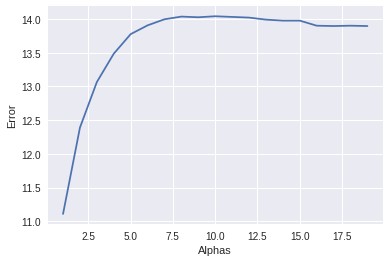

In [0]:
plt.plot(range(1,20),Error)
plt.xlabel("Alphas")
plt.ylabel("Error")

Text(0,0.5,'f1score')

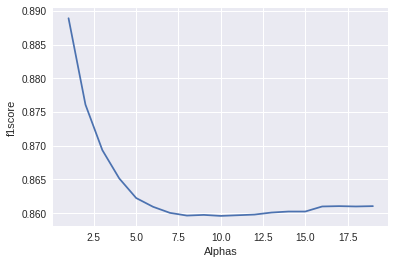

In [0]:
plt.plot(range(1,20),f1score)
plt.xlabel("Alphas")
plt.ylabel("f1score")

In [0]:
test_bag_of_words=count_vect.transform(test_data['CleanedText'])
y_test=np.array(test_data['Score'])

In [0]:

clf = BernoulliNB(alpha=float(1))
clf.fit(bag_of_words, y)
pred = clf.predict(test_bag_of_words)

In [0]:
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
cm=confusion_matrix(y_test, pred)
print(cm)
print('test accuracy for alpha = 1 is {} and  f1-score = {}'.format(acc,f1))

[[ 1250  1428]
 [  827 16495]]
test accuracy for alpha = 1 is 88.725 and  f1-score = 0.88725


In [0]:
def metrics(cm):
    tp=cm[0,0]
    fp=cm[0,1]
    fn=cm[1,0]
    tn=cm[1,1]
  
    TPR=tp/(tp+fn)
    TNR=tn/(tn+fp)
    FNR=1-TPR
    FPR=1-TNR
  
    return "TPR={},  TNR={},  FNR={},  FPR={}".format(TPR,TNR,FNR,FPR)

In [0]:
metrics(cm)

'TPR=0.601829561868079,  TNR=0.9203258383083189,  FNR=0.398170438131921,  FPR=0.07967416169168107'

In [0]:
words=count_vect.get_feature_names()

In [0]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-10:]))

['get' 'buy' 'flavor' 'good' 'tri' 'would' 'one' 'product' 'like' 'tast']
['tri' 'product' 'use' 'one' 'flavor' 'love' 'good' 'great' 'like' 'tast']


In [0]:
!pip install prettytable

In [0]:
from prettytable import PrettyTable
    


#TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 815007)
the number of unique words including both unigrams and bigrams  815007


In [0]:
final_tf_idf.shape

(60000, 815007)

In [0]:
cv_final_tf_idf=tf_idf_vect.transform(cv_data['CleanedText'])

In [0]:
cv_final_tf_idf.shape

(20000, 815007)

In [0]:
accuracy=[]
f1score=[]
for i in range(1,20):

    clf = BernoulliNB(alpha=float(i))
    clf.fit(final_tf_idf, y)
    cv_pred = clf.predict(cv_final_tf_idf)
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    cm=confusion_matrix(y_cv, cv_pred)
    accuracy.append(acc)
    f1score.append(f1)

    



In [0]:
Error=[100-x for x in f1score]

Text(0,0.5,'Error')

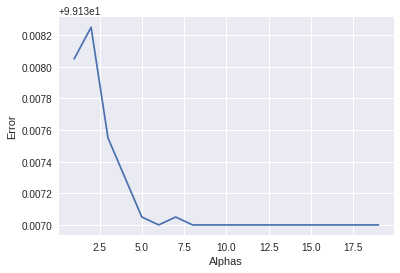

In [0]:
plt.plot(range(1,20),Error)
plt.xlabel("Alphas")
plt.ylabel("Error")

Text(0,0.5,'Error')

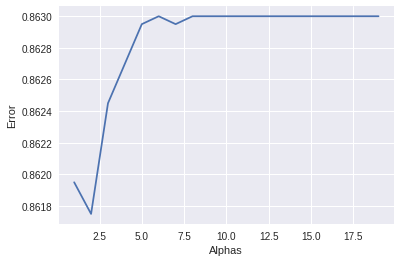

In [0]:
plt.plot(range(1,20),f1score)
plt.xlabel("Alphas")
plt.ylabel("Error")

In [0]:
test_final_tf_idf=tf_idf_vect.transform(test_data['CleanedText'])

In [0]:
clf = BernoulliNB(alpha=float(1))
clf.fit(final_tf_idf, y)
pred = clf.predict(test_final_tf_idf)

In [0]:
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
cm=confusion_matrix(y_test, pred)
print(cm)
print('test accuracy for alpha = 1 is {} and  f1-score = {}'.format(acc,f1))

[[   66  2612]
 [   58 17264]]
test accuracy for alpha = 1 is 86.65 and  f1-score = 0.8665000000000002


In [0]:
metrics(cm)

'TPR=0.532258064516129,  TNR=0.8685852284161804,  FNR=0.467741935483871,  FPR=0.13141477158381965'

In [0]:
clf.feature_log_prob_[0, :][[     0, 511816, 511818, 511819, 511821, 511822, 511825, 511826,
       511827, 511828]]

array([-8.83273359, -8.83273359, -8.83273359, -8.83273359, -8.83273359,
       -8.83273359, -8.83273359, -8.83273359, -8.83273359, -8.83273359])

In [0]:
clf.feature_log_prob_[0, :].min()

-8.832733591996416

In [0]:
clf.feature_log_prob_[1, :].argsort()

array([ 47748, 315938, 107794, ..., 318333, 405401, 708250])

In [0]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[-10:]))

['get' 'buy' 'flavor' 'good' 'tri' 'would' 'one' 'product' 'like' 'tast']
['tri' 'product' 'use' 'one' 'flavor' 'love' 'good' 'great' 'like' 'tast']


# Conclusion

In [0]:
x = PrettyTable()

x.field_names = ["Model", "Best_Alpha", "Train Error", "Test Error"]

x.add_row(["Bag of words", 1, 88.8, 88.7])
x.add_row(["Tf-IDF", 1, 86.19, 86.65])
print(x)

+--------------+------------+-------------+------------+
|    Model     | Best_Alpha | Train Error | Test Error |
+--------------+------------+-------------+------------+
| Bag of words |     1      |     88.8    |    88.7    |
|    Tf-IDF    |     1      |    86.19    |   86.65    |
+--------------+------------+-------------+------------+
